In [2]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [3]:
#fetch the mnist dataset
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [4]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [5]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


In [82]:
#have to change with different number of layers
def params_init():

  #np.random.seed(2)
  W1 = np.random.rand(200,784) - 0.5
  b1 = np.random.rand(200,1) - 0.5
  W2 = np.random.rand(50,200) - 0.5
  b2 = np.random.rand(50,1) - 0.5
  W3 = np.random.rand(10,50) - 0.5 
  b3 = np.random.rand(10,1) - 0.5
  #W4 = np.random.rand(50,200) - 0.5   
  #b4 = np.random.rand(50,1) - 0.5    
  #W5 = np.random.rand(10,50) - 0.5  
  #b5 = np.random.rand(10,1) - 0.5    
  print("Params Initialised")

  return (W1, b1, W2, b2, W3, b3)


#have to change with different number of layers
def forward(x_train, W1, b1, W2, b2, W3, b3):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2 
  A2 = relu(Z2)

  Z3 = np.matmul(W3,A2) + b3
  A3 = softmax(Z3)
  
  #Z4 = np.matmul(W4,A3) + b4
  #A4 = relu(Z4)

  #Z5 = np.matmul(W5,A4) + b5
  #A5 = softmax(Z5)

  #W2 is 10*50, A1 is 50*m
  # print(np.exp(Z2))
  # print(np.sum(np.exp(Z2)))

  #A2 is 10*m, final predictions
  # print("Fp Done")

  return Z1, A1, Z2, A2, Z3, A3


def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  #return np.exp(Z) / np.sum(np.exp(Z),0)
  Z = Z-np.max(Z, axis=0)
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0


def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T


#have to change with different number of layers
def backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, y):
  # print("Entered Backprop")
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ3 = (A3 - Y)
  
  dW3 = 1/m*np.matmul(dZ3,A2.T)

  db3 = 1/m*np.sum(dZ3, axis=1)

  dZ2 = np.matmul(W3.T, dZ3)*relu_d(Z2) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW2 = 1/m*np.matmul(dZ2,A1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db2 = 1/m*np.sum(dZ2, axis=1) #db1 is 50*1

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis = 1) #db1 is 50*1


  return dW1, db1, dW2, db2, dW3, db3


#have to change with different number of layers
def param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))
  W3 = W3 - lr*dW3
  b3 = b3 - lr*(db3.reshape(b3.shape))
  #W4 = W4 - lr*dW4
  #b4 = b4 - lr*db4

  return W1, b1, W2, b2, W3, b3


#have to change with different number of layers
def batch_grad_descent(X,Y,iter, lr, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  weightsDict["W1"] = W1
  weightsDict["b1"] = b1
  weightsDict["W2"] = W2
  weightsDict["b2"] = b2
  weightsDict["W3"] = W3
  weightsDict["b3"] = b3

  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1, b1, W2, b2, W3, b3) 

      dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)


      W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights




def grad_descent(X,Y,iter, lr, print_op, decay_factor=0):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)


  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0
    X1, Y1 = X.T, Y
    X1 = X1.T #take transpose to match the sizes

    Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1, b1, W2, b2, W3, b3) 

    dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)

    W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr, factor = decay_factor)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights



def NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, b1, b2, b3, X1, Y1):
  #calculating dw3 and db3
  #first approximate dZ3
  m = Z3.shape[1]
  lossArrayAfterPertZ3 = np.zeros_like(Z3)
  for i in range(Z3.shape[0]):
    Z3pert = Z3.copy() #creates a local copy of the array since python arrays are sent by reference andnot copy!!
    Z3pert[i] +=  pert
    A3pert = softmax(Z3pert)
    #print("Z3")
    lossArrayAfterPertZ3[i] = np.sum((A3pert-one_hot_encoding(Y1))**2, axis=0)

  
  dZ3 = (lossArrayAfterPertZ3 - lossBeforePert)/pert
  
  dW3 = 1/m*np.matmul(dZ3,A2.T)

  db3 = 1/m*np.sum(dZ3, axis=1)


  #calculating the dZ2 and db2

  lossArrayAfterPertZ2 = np.zeros_like(Z2)

  for i in range(Z2.shape[0]):
    Z2pert = Z2.copy()
    Z2pert[i] += pert

    A2pert = relu(Z2pert)

    Z3pert = np.matmul(W3,A2pert) + b3
    A3pert = softmax(Z3pert)
    #print("Z2")
    lossArrayAfterPertZ2[i] = np.sum((A3pert-one_hot_encoding(Y1))**2, axis=0)

  
  dZ2 = (lossArrayAfterPertZ2 - lossBeforePert)/pert

  dW2 = 1/m*np.matmul(dZ2,A1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db2 = 1/m*np.sum(dZ2, axis=1) #db1 is 50*1

  #calculating the dZ1 and db1
  lossArrayAfterPertZ1 = np.zeros_like(Z1)
  for i in range(Z1.shape[0]):
    Z1pert = Z1.copy()
    Z1pert[i] += pert

    A1pert = relu(Z1pert)

    Z2pert = np.matmul(W2,A1pert) + b2 
    A2pert = relu(Z2pert)

    Z3pert = np.matmul(W3,A2pert) + b3
    A3pert = softmax(Z3pert)
    #print("Z1")
    #print(f"sub sub in iter{i}")

    lossArrayAfterPertZ1[i] = np.sum((A3pert-one_hot_encoding(Y1))**2, axis=0)

  dZ1 = (lossArrayAfterPertZ1 - lossBeforePert)/pert

  dW1 = 1/m*np.matmul(dZ1,X1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis = 1) #db1 is 50*1

  return dW1, db1, dW2, db2, dW3, db3



def batchGDNP(X,Y,iter, lr, pert, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  n = Y.shape[0]
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  weightsDict["W1"] = W1
  weightsDict["b1"] = b1
  weightsDict["W2"] = W2
  weightsDict["b2"] = b2
  weightsDict["W3"] = W3
  weightsDict["b3"] = b3

  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0


    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1, b1, W2, b2, W3, b3) 
      print(f"Iter {i} -> sub iter {j} : {accuracy(predictions(A3), Y1)}", end = "\r", flush = True)
      lossBeforePert = np.sum((A3-one_hot_encoding(Y1))**2, axis=0)

      #print(f"Main iter: {i} Sub iter : {j}\n")
      #dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)
      dW1, db1, dW2, db2, dW3, db3 = NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, b1, b2, b3, X1, Y1)
      #print(f"iter in iter{j}")
      W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr)
      #print(W1)

    if (i+1)%(print_op) == 0:
      print(f'\nIteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights




def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/(Y.shape[0])*100


In [83]:
epochsToTrain = 100

In [84]:
W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights = batchGDNP(x_train,y_train,epochsToTrain, 0.01, 0.01, 1)


Params Initialised
Iteration: 1b iter 99 : 17.619047619047624
Train accuracy: 17.08730158730159
Val accuracy: 17.4
Iteration: 2b iter 99 : 21.269841269841275
Train accuracy: 20.144444444444446
Val accuracy: 20.65714285714286
Iteration: 3b iter 99 : 23.492063492063492
Train accuracy: 22.306349206349207
Val accuracy: 22.642857142857142
Iteration: 4b iter 99 : 26.031746031746035
Train accuracy: 24.312698412698413
Val accuracy: 24.442857142857143
Iteration: 5b iter 99 : 31.587301587301585
Train accuracy: 30.160317460317458
Val accuracy: 30.685714285714287
Iteration: 6b iter 99 : 34.761904761904763
Train accuracy: 34.26825396825397
Val accuracy: 34.85714285714286
Iteration: 7b iter 99 : 40.634920634920635
Train accuracy: 39.51269841269841
Val accuracy: 40.24285714285714
Iteration: 8b iter 99 : 43.015873015873026
Train accuracy: 43.67777777777778
Val accuracy: 44.471428571428575
Iteration: 9b iter 99 : 46.349206349206354
Train accuracy: 46.52222222222222
Val accuracy: 46.84285714285714
Itera

In [88]:
W1, b1, W2, b2, W3, b3, train_acc_bp, val_acc_bp, train_loss_bp, val_loss_bp, sum_weights_bp = batch_grad_descent(x_train,y_train,epochsToTrain, 0.01,1)

Params Initialised
Iteration: 1
Train accuracy: 60.57142857142858
Val accuracy: 59.65714285714285
Iteration: 2
Train accuracy: 70.14285714285714
Val accuracy: 68.72857142857143
Iteration: 3
Train accuracy: 74.4920634920635
Val accuracy: 73.72857142857143
Iteration: 4
Train accuracy: 77.22063492063492
Val accuracy: 76.67142857142856
Iteration: 5
Train accuracy: 79.03333333333333
Val accuracy: 78.37142857142857
Iteration: 6
Train accuracy: 80.48730158730159
Val accuracy: 79.82857142857142
Iteration: 7
Train accuracy: 81.65238095238095
Val accuracy: 80.94285714285714
Iteration: 8
Train accuracy: 82.57460317460318
Val accuracy: 81.65714285714286
Iteration: 9
Train accuracy: 83.30634920634921
Val accuracy: 82.54285714285714
Iteration: 10
Train accuracy: 84.01111111111112
Val accuracy: 83.2
Iteration: 11
Train accuracy: 84.6
Val accuracy: 83.85714285714285
Iteration: 12
Train accuracy: 85.0920634920635
Val accuracy: 84.35714285714285
Iteration: 13
Train accuracy: 85.5079365079365
Val accurac

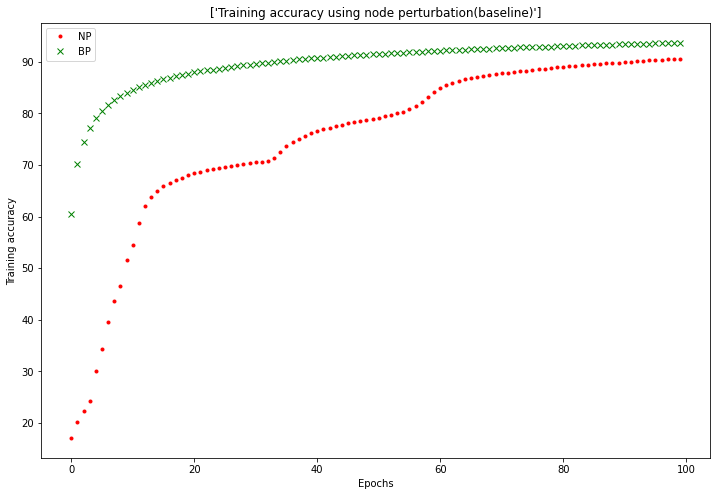

In [89]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, "r.")
plt.plot(train_acc_bp, "gx")
plt.title(["Training accuracy using node perturbation(baseline)"])
plt.xlabel("Epochs", size=10)
plt.ylabel("Training accuracy", size = 10)
plt.legend(["NP", "BP"])

In [54]:
Y = one_hot_encoding(y_train)
Y.shape

(10, 63000)

In [74]:
W1, b1, W2, b2, W3, b3 = params_init()
Z1, A1, Z2, A2, Z3, A3 = forward(x_train, W1, b1, W2, b2, W3, b3)

Params Initialised


In [75]:
accuracy(predictions(A3), y_train)

13.026984126984125

In [50]:
Z1 = Z1- np.max(Z1, axis=0)

In [52]:
Z1

array([[-12.25566136,  -9.77496698,  -8.79695744, ...,  -7.80636298,
        -15.92526741, -20.02611282],
       [ -9.72121696,  -6.22091867,  -4.8731629 , ...,  -2.55752564,
         -6.59775347,  -8.95087339],
       [ -9.92643277,  -7.37246957,  -4.52480223, ...,  -4.3854183 ,
         -7.4639615 , -14.91604123],
       ...,
       [ -9.19078321, -10.62944845,  -5.44019187, ...,  -7.29793901,
         -8.65648547, -15.0731984 ],
       [-10.07853589,  -7.45615704,  -4.86311216, ...,  -3.71657699,
         -6.66754462,  -9.58466006],
       [ -9.76332042,  -9.69017676,  -7.12985019, ...,  -3.66609792,
         -7.81213824, -11.37297805]])

In [51]:
np.exp(Z1)/np.sum(np.exp(Z1),0)

array([[3.79819857e-06, 1.57063805e-05, 2.90428273e-05, ...,
        4.92898014e-05, 5.26667133e-08, 1.95759529e-09],
       [4.78930925e-05, 5.49009277e-04, 1.46933629e-03, ...,
        9.38205907e-03, 5.92139527e-04, 1.26368340e-04],
       [3.90075601e-05, 1.73567131e-04, 2.08167210e-03, ...,
        1.50818448e-03, 2.49020261e-04, 3.24338723e-07],
       ...,
       [8.14024228e-05, 6.68312413e-06, 8.33419493e-04, ...,
        8.19526110e-05, 7.55662908e-05, 2.77170056e-07],
       [3.35035820e-05, 1.59632927e-04, 1.48417867e-03, ...,
        2.94393730e-03, 5.52222552e-04, 6.70483701e-05],
       [4.59184882e-05, 1.70962177e-05, 1.53834721e-04, ...,
        3.09635923e-03, 1.75801852e-04, 1.12132523e-05]])

In [17]:
m = Z3.shape[1]
pert = 0.1
lossBeforePert = np.sum((A3-one_hot_encoding(y_train))**2, axis=0)
lossArrayAfterPertZ3 = np.zeros_like(Z3)
for i in range(Z3.shape[0]):
    Z3pert = Z3.copy() #creates a local copy of the array since python arrays are sent by reference andnot copy!!
    Z3pert[i] +=  pert
    A3pert = softmax(Z3pert)
    lossArrayAfterPertZ3[i] = np.sum((A3pert-one_hot_encoding(y_train))**2, axis=0)


dZ3 = (lossArrayAfterPertZ3 - lossBeforePert)/pert

dW3 = 1/m*np.matmul(dZ3,A2.T)

db3 = 1/m*np.sum(dZ3, axis=1)

In [18]:
lossArrayAfterPertZ2 = np.zeros_like(Z2)

for i in range(Z2.shape[0]):
    Z2pert = Z2.copy()
    Z2pert[i] += pert

    A2pert = relu(Z2pert)

    Z3pert = np.matmul(W3,A2pert) + b3
    A3pert = softmax(Z3pert)
    lossArrayAfterPertZ2[i] = np.sum((A3pert-one_hot_encoding(y_train))**2, axis=0)


dZ2 = (lossArrayAfterPertZ2 - lossBeforePert)/pert

dW2 = 1/m*np.matmul(dZ2,A1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

db2 = 1/m*np.sum(dZ2, axis=1) #db1 is 50*1


In [19]:
dW2

array([[-3.44652722e-05, -1.91071142e-03, -6.83915406e-04, ...,
         1.04829187e-04, -1.18278904e-03, -7.32349391e-05],
       [ 6.67987678e-05, -6.42835995e-03, -3.27877653e-04, ...,
         7.59078499e-04,  5.46900503e-04, -5.25011768e-03],
       [ 1.47084256e-04,  7.05337784e-03,  3.20616679e-03, ...,
         8.04822963e-04,  1.13577690e-03,  9.12609766e-03],
       ...,
       [ 7.65987155e-05,  5.07250451e-03, -2.77136700e-03, ...,
        -7.51528691e-04,  1.75562552e-03, -5.69986091e-04],
       [ 1.66104750e-04,  4.44860294e-03, -1.58931222e-04, ...,
        -2.10381943e-04,  2.30341943e-04,  3.00307195e-03],
       [ 2.78581124e-07,  1.40669897e-04,  9.54493959e-05, ...,
         3.54828288e-05,  1.59083036e-04,  2.20893989e-04]])

In [70]:
lossArrayAfterPertZ1 = np.zeros_like(Z1)
for i in range(Z1.shape[0]):
    Z1pert = Z1.copy()
    Z1pert[i] += pert

    A1pert = relu(Z1pert)

    Z2pert = np.matmul(W2,A1pert) + b2 
    A2pert = relu(Z2pert)

    Z3pert = np.matmul(W3,A2pert) + b3
    A3pert = softmax(Z3pert)
    print(f"sub iter: {i}")

    lossArrayAfterPertZ1[i] = np.sum((A3pert-one_hot_encoding(y_train))**2, axis=0)

dZ1 = (lossArrayAfterPertZ1 - lossBeforePert)/pert

dW1 = 1/m*np.matmul(dZ1,x_train.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

db1 = 1/m*np.sum(dZ1, axis = 1) #db1 is 50*1

sub iter: 0
sub iter: 1
sub iter: 2
sub iter: 3
sub iter: 4
sub iter: 5
sub iter: 6
sub iter: 7
sub iter: 8
sub iter: 9
sub iter: 10
sub iter: 11
sub iter: 12
sub iter: 13
sub iter: 14
sub iter: 15
sub iter: 16
sub iter: 17
sub iter: 18
sub iter: 19
sub iter: 20
sub iter: 21
sub iter: 22
sub iter: 23
sub iter: 24
sub iter: 25
sub iter: 26
sub iter: 27
sub iter: 28
sub iter: 29
sub iter: 30
sub iter: 31
sub iter: 32
sub iter: 33
sub iter: 34
sub iter: 35
sub iter: 36
sub iter: 37
sub iter: 38
sub iter: 39
sub iter: 40
sub iter: 41
sub iter: 42
sub iter: 43


KeyboardInterrupt: 

In [109]:
lossArrayAfterPertZ3

array([[1.99999689, 1.90408986, 1.99817536, ..., 1.45310182, 0.0673587 ,
        1.51451512],
       [1.99999689, 1.90410139, 1.99817758, ..., 1.45310182, 0.07905707,
        1.52943448],
       [1.99999689, 1.90410138, 1.99817758, ..., 1.45310174, 0.07905707,
        1.52943404],
       ...,
       [1.99999689, 1.90410139, 1.99817743, ..., 1.44761844, 0.07906075,
        1.56006023],
       [1.99999689, 1.90410131, 1.99809366, ..., 1.45310182, 0.07905746,
        1.52942324],
       [1.99999689, 1.8981823 , 1.99817747, ..., 1.44839261, 0.09191522,
        1.52362005]])

In [2]:
import test.py

In [102]:
Z1.shape

(200, 63000)

In [58]:
np.sum((A3-Y)**2, axis=0).shape

(63000,)

In [39]:
a = np.array([[1,2], [4,5], [56, 67]])
a

array([[ 1,  2],
       [ 4,  5],
       [56, 67]])

In [50]:
b = np.random.randint(1, 200, (6, 10))
b

array([[ 59,  67, 126, 113,  63, 133,  29, 134, 135, 169],
       [126, 163, 171,  33,  81,  89, 178, 175, 114, 159],
       [124, 110,  47, 114,  85, 175, 122,  30, 175,   8],
       [101,  16,  33,  15,  25, 149,  98,  48,  61, 196],
       [ 40, 107, 143,  19, 177,   2,  18,  20, 191, 118],
       [ 61,  55, 136, 176,  18,  23,  66,  34, 145, 142]])

In [43]:
b[4]

array([ 59,  14,  35, 133,  88, 191, 129,  52, 174, 143])

In [51]:
def myfunc(a):
    c = a.copy()
    c[1] += 4
    return c

In [52]:
c = myfunc(b)
c

array([[ 59,  67, 126, 113,  63, 133,  29, 134, 135, 169],
       [130, 167, 175,  37,  85,  93, 182, 179, 118, 163],
       [124, 110,  47, 114,  85, 175, 122,  30, 175,   8],
       [101,  16,  33,  15,  25, 149,  98,  48,  61, 196],
       [ 40, 107, 143,  19, 177,   2,  18,  20, 191, 118],
       [ 61,  55, 136, 176,  18,  23,  66,  34, 145, 142]])

In [53]:
b

array([[ 59,  67, 126, 113,  63, 133,  29, 134, 135, 169],
       [126, 163, 171,  33,  81,  89, 178, 175, 114, 159],
       [124, 110,  47, 114,  85, 175, 122,  30, 175,   8],
       [101,  16,  33,  15,  25, 149,  98,  48,  61, 196],
       [ 40, 107, 143,  19, 177,   2,  18,  20, 191, 118],
       [ 61,  55, 136, 176,  18,  23,  66,  34, 145, 142]])

In [36]:
ss = np.vectorize(myfunc)
ss(a, 4)

array([[   5,    8],
       [  20,   29],
       [3140, 4493]])

In [71]:
a = np.array()

TypeError: array() missing required argument 'object' (pos 0)

In [64]:
np.append(a, np.array([1,2]), axis=0)

array([1., 2.])

In [67]:
np.append(a, [np.array([3,55])], axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [70]:
np.vstack([a, np.array([1,2])])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 2

In [1]:
import multiprocessing  
import random
from multiprocessing import Pool
import test



if __name__ == '__main__':
    pool = Pool()
    to_factor = [ random.randint(100000, 50000000) for i in range(20)]
    results = pool.map(test.prime_factor, to_factor)
    for value, factors in zip(to_factor, results):
        print("The factors of {} are {}".format(value, factors))

The factors of 12324049 are [12324049, 1597, 7717]
The factors of 880325 are [880325, 5, 176065, 5, 35213, 23, 1531]
The factors of 35468037 are [35468037, 11822679, 3940893, 1313631, 437877, 145959, 48653, 11, 4423]
The factors of 11931245 are [11931245, 5, 2386249, 179, 13331]
The factors of 44357249 are [44357249, 31, 1430879]
The factors of 28560023 are [28560023, 67, 426269, 439, 971]
The factors of 20507042 are [10253521, 19, 539659, 109, 4951]
The factors of 28460977 are [28460977, 29, 981413, 613, 1601]
The factors of 34336910 are [17168455, 5, 3433691]
The factors of 24294129 are [24294129, 8098043]
The factors of 4310270 are [2155135, 5, 431027, 29, 14863, 89, 167]
The factors of 30462664 are [3807833]
The factors of 3195983 are [3195983, 7, 456569, 17, 26857, 107, 251]
The factors of 31280688 are [1955043, 651681, 217227, 72409, 19, 3811, 37, 103]
The factors of 47429094 are [23714547, 7904849, 29, 272581]
The factors of 37800281 are [37800281]
The factors of 27288491 are [2